<a href="https://colab.research.google.com/github/mxxsxx08/FinalPreprocessing/blob/main/models_resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import

In [2]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, f1_score
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')
import kagglehub
path = kagglehub.dataset_download("asjad99/mimiciii")
print(path)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

/kaggle/input/mimiciii


In [3]:
#!pip install --upgrade --force-reinstall torch torchvision torchaudio

In [4]:
df_PATIENTS = pd.read_csv('/kaggle/input/mimiciii/mimic-iii-clinical-database-demo-1.4/PATIENTS.csv')
df_CHARTEVENTS = pd.read_csv('/kaggle/input/mimiciii/mimic-iii-clinical-database-demo-1.4/CHARTEVENTS.csv')
df_ADMISSIONS = pd.read_csv('/kaggle/input/mimiciii/mimic-iii-clinical-database-demo-1.4/ADMISSIONS.csv')
df_D_ITEMS = pd.read_csv('/kaggle/input/mimiciii/mimic-iii-clinical-database-demo-1.4/D_ITEMS.csv')

df_ADMISSIONS = df_ADMISSIONS[df_ADMISSIONS['subject_id'] != 10120]
df_PATIENTS = df_PATIENTS[df_PATIENTS['subject_id'] != 10120]

df_PATIENTS = df_PATIENTS.loc[:,['subject_id','gender']]

# 2. 전처리


In [6]:
df_CHARTEVENTS['value'] = pd.to_numeric(df_CHARTEVENTS['value'], errors='coerce')
df_pivot = df_CHARTEVENTS[df_CHARTEVENTS['itemid'].isin([211, 618, 646])].loc[:,['subject_id','itemid','value','charttime']]\
.pivot_table(
    index=['subject_id', 'charttime'],
    columns='itemid',
    values='value'
).reset_index()
df_pivot = df_pivot.sort_values(by=['subject_id', 'charttime'])
df_pivot = df_pivot.rename(columns={211: 'Heart_Rate', 618: 'Resp_Rate', 646: 'SpO2'})

# NAN 채우기
# 각 subject_id별 평균 구하기
subject_means = df_pivot.groupby("subject_id")[["Heart_Rate", "Resp_Rate", "SpO2"]].transform("mean")

# NaN 값을 각 subject의 평균으로 채우기
df_pivot_filled = df_pivot.copy()
df_pivot_filled[["Heart_Rate", "Resp_Rate", "SpO2"]] = df_pivot[["Heart_Rate", "Resp_Rate", "SpO2"]].fillna(subject_means)

# datetime 형식으로 변환
df_pivot_filled['charttime'] = pd.to_datetime(df_pivot_filled['charttime'])

df_ADMISSIONS_flag = df_ADMISSIONS.loc[:,['subject_id','hospital_expire_flag']]

# 조인
df_merged = pd.merge(df_pivot_filled, df_ADMISSIONS_flag, on='subject_id', how='left')

In [7]:
df_ADMISSIONS_select = df_ADMISSIONS.loc[:,['subject_id','admission_type','admission_location','discharge_location',
                     'insurance','marital_status','ethnicity','diagnosis','hospital_expire_flag']]

df_ADMISSIONS_select_s = pd.merge(df_PATIENTS, df_ADMISSIONS_select, on='subject_id', how='left').drop(['hospital_expire_flag'],axis=1)
df_mgd = pd.merge(df_merged, df_ADMISSIONS_select_s, on='subject_id', how='left')
df_mgd['charttime'] = pd.to_datetime(df_mgd['charttime'])
df_mgd = df_mgd.drop(['charttime','Heart_Rate','Resp_Rate','SpO2'],axis=1)

In [8]:
import torchvision.models as models

# 정적 컬럼 지정
static_cols = [
    'gender', 'admission_type', 'admission_location', 'discharge_location',
    'insurance', 'marital_status', 'ethnicity'
]
target_col = 'hospital_expire_flag'

# 원본 정적 데이터
df_static = df_mgd[static_cols + [target_col]].copy()

# 라벨 인코딩 (문자형 → 숫자)
label_encoders = {}
for col in static_cols:
    le = LabelEncoder()
    df_static[col] = df_static[col].fillna('UNKNOWN')
    df_static[col] = le.fit_transform(df_static[col])
    label_encoders[col] = le

# 입력과 타겟 분리
X = df_static[static_cols].values
y = df_static[target_col].values

# 패딩 후 2D reshape: CNN 입력용 (1, 4, 4)
if X.shape[1] < 16:
    X = np.pad(X, ((0, 0), (0, 16 - X.shape[1])), mode='constant')

X_cnn = X.reshape(-1, 1, 4, 4)
X_cnn = np.repeat(X_cnn, 3, axis=1)

X_tensor = torch.tensor(X_cnn, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

model = models.resnet18(pretrained=False)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 1),
    nn.Sigmoid()
)

# 3. 모델


Epoch 1 | Train Loss: 0.3758
Epoch 2 | Train Loss: 0.3308
Epoch 3 | Train Loss: 0.3334
Epoch 4 | Train Loss: 0.3089
Epoch 5 | Train Loss: 0.2869
Epoch 6 | Train Loss: 0.2834
Epoch 7 | Train Loss: 0.2915
Epoch 8 | Train Loss: 0.2865
Epoch 9 | Train Loss: 0.2744
Epoch 10 | Train Loss: 0.2742
Epoch 11 | Train Loss: 0.2741
Epoch 12 | Train Loss: 0.2852
Epoch 13 | Train Loss: 0.2857
Epoch 14 | Train Loss: 0.2691
Epoch 15 | Train Loss: 0.2620
Epoch 16 | Train Loss: 0.2668
Epoch 17 | Train Loss: 0.2721
Epoch 18 | Train Loss: 0.2684
Epoch 19 | Train Loss: 0.2562
Epoch 20 | Train Loss: 0.2616


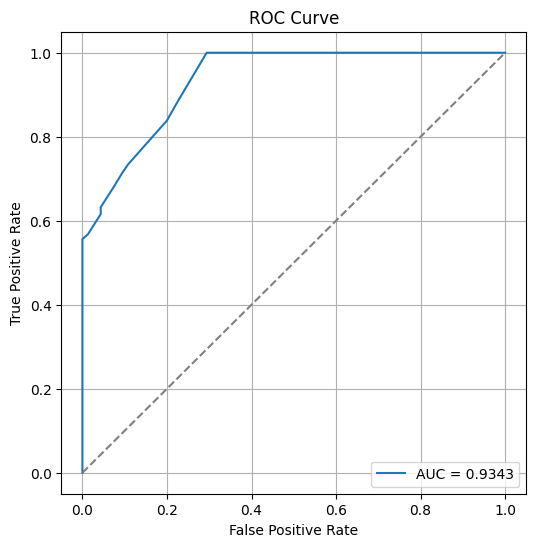

✅ Accuracy: 0.8160
✅ F1 Score: 0.7908


In [9]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=16)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 루프
for epoch in range(20):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch+1} | Train Loss: {train_loss / len(train_loader):.4f}")

# 검증 데이터로 예측
model.eval()
with torch.no_grad():
    y_pred = model(X_val).numpy()  # 예측 확률
    y_true = y_val.numpy()         # 실제 정답
    y_pred_label = (y_pred > 0.5).astype(int)  # 확률 → 0 또는 1

# 평가 지표 출력
acc = accuracy_score(y_true, y_pred_label)
f1 = f1_score(y_true, y_pred_label)

model.eval()
with torch.no_grad():
    y_pred = model(X_val).numpy()
    y_true = y_val.numpy()
    y_pred_label = (y_pred > 0.5).astype(int)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ F1 Score: {f1:.4f}")